# Conexión a Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerias requeridas

In [ ]:
!pip install -U scikit-learn==0.22

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 3.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22 which is incompatible.


In [ ]:
import cv2
import math
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import exists
import sys
import tensorflow as tf
import imutils
import pickle
import numpy as np
import pandas as pd
import joblib as jb

from genericpath import exists
from PIL import Image
from tqdm import tqdm
from multiprocessing import Pool
from sklearn.model_selection import train_test_split 

In [ ]:
device_id = 0

# numero de imagenes por archivo de entrenamiento o validación
lotes = 2000

# MOUNTED_GOOGLE = os.path.join('/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS')
# MOUNTED_GOOGLE = os.path.join('G:\\Mi unidad\\ESTUDIO\\UNIANDES\\TESIS')

MOUNTED_GOOGLE = os.path.join('/content/drive/MyDrive/TESIS')

BASE_METRICAS = os.path.join(MOUNTED_GOOGLE, "Metricas", "sub_df")
BASE_CODIGOS = os.path.join(MOUNTED_GOOGLE, "Prototipo", "Codigos")
BASE_DATASET = os.path.join(MOUNTED_GOOGLE, "Prototipo", "Datasets")

# Ruta para cada dataSet
BASE_CASIA = os.path.join(BASE_DATASET, "CASIA", "frames", "frames")
BASE_CASIA_TRAIN = os.path.join(BASE_CASIA, "train_release")
BASE_CASIA_TEST = os.path.join(BASE_CASIA, "test_release")

BASE_CASIA_SUBSTITUTION = os.path.join(BASE_DATASET, "CASIA_SUBSTITUTION", "frames", "frames", "train_release")

BASE_CASIA_DIFFUSION = os.path.join(BASE_DATASET, "CASIA_DIFFUSION", "frames")

BASE_StyleGAN_LOCAL = os.path.join(BASE_DATASET, "StyleGAN")
BASE_StyleGAN = os.path.join(BASE_StyleGAN_LOCAL, "ffhq-1024x1024")

# Base para modelo de clasificación
BASE_SILENT_FAS = os.path.join(BASE_CODIGOS, "FAS", "0_Silent_FAS")
BASE_LD_FAS = os.path.join(BASE_CODIGOS, "FAS", "1_Liveness_Detection_FAS")
BASE_O_FAS = os.path.join(BASE_CODIGOS, "FAS", "2_Objects_FAS")

# Guardar resultados de la clasificación de test

RESULT_CASIA = os.path.join(BASE_METRICAS, "CASIA")
RESULT_CASIA_DIFFUSION = os.path.join(BASE_METRICAS, "CASIA_DIFFUSION")
RESULT_CASIA_SUBSTITUTION = os.path.join(BASE_METRICAS, "CASIA_SUBSTITUTION")
RESULT_StyleGAN = os.path.join(BASE_METRICAS, "StyleGAN")

# Estandar ISO


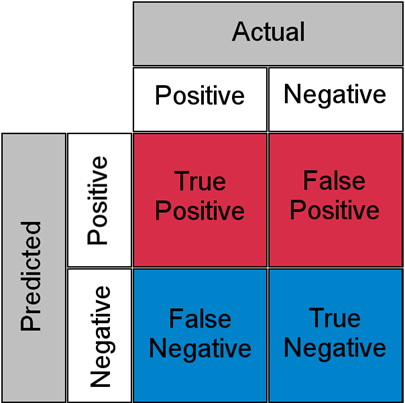

$Instrumentos de Ataques de Presentación (PAI)$, los cuales son instrumentos de ataque de presentación basados en un medio y método de producción comunes y una única fuente de características biométricas, para esta investigación los PAI son el conjunto de imágenes falsas o imágenes con marcación de $0$ o Negativas

Tasa de error de clasificación de ataques de presentación (APCER), el cual consiste en la proporción de presentaciones de ataques que usan las mismas PAI clasificadas incorrectamente como presentaciones correctas en un escenario específico (i.e. Todas las imágenes de ataques clasificadas como reales o positivas). 

$APCER = FP / ( FP + TN )$

Tasa de error de clasificación de presentación normal o de buena fe (NPCER/BPCER), el cual consiste en proporción de presentaciones de reales clasificadas incorrectamente como ataques de presentación en un escenario específico (i.e. imágenes reales clasificadas como falsas o negativas)

$NPCER = FN / ( FN + TP )$

Tasa de error de clasificación promedio (ACER)

$ACER = ( APCER + NPCER ) / 2$

Tasa de falsos positivos (FPR):

$FPR = FP / ( FP + TN )$

Tasa de verdaderos positivos (TPR):

$TPR = TP / ( TP + FN )$

$PRECISION = TP / ( TP + FP )$

$RECALL = TP / ( TP + FN )$

$TP$: Cuando las imágenes reales son clasificadas como reales

$TN$: Cuando las imágenes falsas son clasificadas como falsas

$FP$: Cuando las imágenes falsas son clasificadas como reales

$FN$: Cuando las imágenes reales son clasificadas como falsas


# Métricas con todo el conjunto de imagenes

## CASIA


### Recopilación de resultados por modelo FAS

#### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
PATH_RESULTS_SFAS = BASE_CODIGOS + "/FAS/0_Silent_FAS/results/CASIA"
TOTAL_RESULTS_SFAS = []
df = []
for log in os.listdir(PATH_RESULTS_SFAS):
    df = pd.read_csv(PATH_RESULTS_SFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        if raw[1] in ["1", "2", "HR_1"]:
            label = 1
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_SFAS.append(df)

TOTAL_RESULTS_SFAS = pd.concat(TOTAL_RESULTS_SFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_SFAS.head()

,Person,Video,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,1,1,200,0,200,1.00,0.0,1
1,1,2,132,0,132,0.93,0.0,1
2,1,3,0,300,300,0.00,1.0,0
3,1,4,0,202,202,0.00,1.0,0
4,1,5,0,209,209,0.00,1.0,0


In [ ]:
print("Real img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == 1].Real.sum())
print("Fake img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == 1].Fake.sum())
print("Total img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == 1].Total_Image.sum())

Real img 358
Fake img 1966
Total img 2324


#### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
PATH_RESULTS_LDFAS = BASE_CODIGOS + "/FAS/1_Liveness_Detection_FAS/results/CASIA"
TOTAL_RESULTS_LDFAS = []
df.drop(df.index, inplace=True)
for log in os.listdir(PATH_RESULTS_LDFAS):
    df = pd.read_csv(PATH_RESULTS_LDFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        if raw[1] in ["1", "2", "HR_1"]:
            label = 1
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_LDFAS.append(df)

TOTAL_RESULTS_LDFAS = pd.concat(TOTAL_RESULTS_LDFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_LDFAS.head()

,Person,Video,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,1,1,0,200,200,0.00,0.95,1
1,1,2,0,132,132,0.00,0.68,1
2,1,3,6,294,300,0.01,0.89,0
3,1,4,182,20,202,0.77,0.07,0
4,1,5,0,209,209,0.00,0.94,0


In [ ]:
print("Real img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == 1].Real.sum())
print("Fake img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == 1].Fake.sum())
print("Total img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == 1].Total_Image.sum())

Real img 982
Fake img 1342
Total img 2324


#### lectura de resultados de clasificación con Objects_FAS

In [ ]:
PATH_RESULTS_OFAS = BASE_CODIGOS + "/FAS/2_Objects_FAS/results/CASIA"
TOTAL_RESULTS_OFAS = []
df.drop(df.index, inplace=True)
for log in os.listdir(PATH_RESULTS_OFAS):
    df = pd.read_csv(PATH_RESULTS_OFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        if raw[1] in ["1", "2", "HR_1"]:
            label = 1
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_OFAS.append(df)

TOTAL_RESULTS_OFAS = pd.concat(TOTAL_RESULTS_OFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_OFAS.head()

,Person,Video,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,1,1,43,157,200,0.16,0.54,1
1,1,2,5,127,132,0.03,0.56,1
2,1,3,55,245,300,0.14,0.47,0
3,1,4,206,66,202,0.78,0.25,0
4,1,5,29,180,209,0.10,0.74,0


In [ ]:
print("Real img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == 1].Real.sum())
print("Fake img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == 1].Fake.sum())
print("Total img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == 1].Total_Image.sum())

Real img 801
Fake img 1593
Total img 2324


### Metrícas según estandar de ISO

#### Metrícas con modelo Silent_FAS

In [ ]:
TP = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 8124
FP 10
FN 2550
TN 30673

APCER 0.0003
NPCER 0.2389
ACER 0.1196
FPR 0.0003
TPR 0.7611

PRECISION 0.9988
RECALL 0.7611


#### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 7185
FP 16427
FN 3489
TN 14256

APCER 0.5354
NPCER 0.3269
ACER 0.4311
FPR 0.5354
TPR 0.6731

PRECISION 0.3043
RECALL 0.6731


#### Metrícas con modelo Object_FAS

In [ ]:
TP = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 3504
FP 12108
FN 7272
TN 18808

APCER 0.3916
NPCER 0.6748
ACER 0.5332
FPR 0.3916
TPR 0.3252

PRECISION 0.2244
RECALL 0.3252


## StyleGAN

### Recopilación de resultados por modelo FAS

#### lectura de resultados de clasificación con Silent_FAS

In [ ]:
PATH_RESULTS_SFAS = BASE_CODIGOS + "/FAS/0_Silent_FAS/results/StyleGAN"
TOTAL_RESULTS_SFAS = []
df = []
for log in os.listdir(PATH_RESULTS_SFAS):
    df = pd.read_csv(PATH_RESULTS_SFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_SFAS.append(df)

TOTAL_RESULTS_SFAS = pd.concat(TOTAL_RESULTS_SFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_SFAS.head()

,Person,Video,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,stylegan2-config-f-psi-0.5,0,994,7,1001,0.97,0.00,0
1,stylegan2-config-f-psi-0.5,1000,992,9,1001,0.97,0.01,0
2,stylegan2-config-f-psi-0.5,2000,993,8,1001,0.97,0.01,0
3,stylegan2-config-f-psi-0.5,3000,989,12,1001,0.96,0.01,0
4,stylegan2-config-f-psi-0.5,4000,989,12,1001,0.96,0.01,0


In [ ]:
print("Real img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == "stylegan2-config-f-psi-0.5"].Real.sum())
print("Fake img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == "stylegan2-config-f-psi-0.5"].Fake.sum())
print("Total img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == "stylegan2-config-f-psi-0.5"].Total_Image.sum())

Real img 94841
Fake img 5259
Total img 100100


In [ ]:
print("Real img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == "stylegan2-config-f-psi-1.0"].Real.sum())
print("Fake img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == "stylegan2-config-f-psi-1.0"].Fake.sum())
print("Total img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == "stylegan2-config-f-psi-1.0"].Total_Image.sum())

Real img 87195
Fake img 12905
Total img 100100


#### lectura de resultados de clasificación con LD_FAS

In [ ]:
PATH_RESULTS_LDFAS = BASE_CODIGOS + "/FAS/1_Liveness_Detection_FAS/results/StyleGAN"
TOTAL_RESULTS_LDFAS = []
df.drop(df.index, inplace=True)
for log in os.listdir(PATH_RESULTS_LDFAS):
    df = pd.read_csv(PATH_RESULTS_LDFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_LDFAS.append(df)

TOTAL_RESULTS_LDFAS = pd.concat(TOTAL_RESULTS_LDFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_LDFAS.head()

,Person,Video,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,stylegan2-config-f-psi-0.5,0,984,19,1001,0.97,0.02,0
1,stylegan2-config-f-psi-0.5,1000,977,25,1001,0.96,0.02,0
2,stylegan2-config-f-psi-0.5,2000,981,21,1001,0.97,0.02,0
3,stylegan2-config-f-psi-0.5,3000,985,17,1001,0.97,0.01,0
4,stylegan2-config-f-psi-0.5,4000,977,24,1001,0.97,0.02,0


In [ ]:
print("Real img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == "stylegan2-config-f-psi-0.5"].Real.sum())
print("Fake img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == "stylegan2-config-f-psi-0.5"].Fake.sum())
print("Total img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == "stylegan2-config-f-psi-0.5"].Total_Image.sum())

Real img 95108
Fake img 5116
Total img 100100


In [ ]:
print("Real img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == "stylegan2-config-f-psi-1.0"].Real.sum())
print("Fake img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == "stylegan2-config-f-psi-1.0"].Fake.sum())
print("Total img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == "stylegan2-config-f-psi-1.0"].Total_Image.sum())

Real img 79798
Fake img 21235
Total img 100100


#### lectura de resultados de clasificación con O_FAS

In [ ]:
PATH_RESULTS_OFAS = BASE_CODIGOS + "/FAS/2_Objects_FAS/results/StyleGAN"
TOTAL_RESULTS_OFAS = []
df.drop(df.index, inplace=True)
for log in os.listdir(PATH_RESULTS_OFAS):
    df = pd.read_csv(PATH_RESULTS_OFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_OFAS.append(df)

TOTAL_RESULTS_OFAS = pd.concat(TOTAL_RESULTS_OFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_OFAS.head()

,Person,Video,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,stylegan2-config-f-psi-0.5,0,400,610,1001,0.33,0.35,0
1,stylegan2-config-f-psi-0.5,1000,408,595,1001,0.34,0.34,0
2,stylegan2-config-f-psi-0.5,2000,425,578,1001,0.35,0.33,0
3,stylegan2-config-f-psi-0.5,3000,414,591,1001,0.34,0.34,0
4,stylegan2-config-f-psi-0.5,4000,410,600,1001,0.34,0.35,0


In [ ]:
print("Real img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == "stylegan2-config-f-psi-0.5"].Real.sum())
print("Fake img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == "stylegan2-config-f-psi-0.5"].Fake.sum())
print("Total img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == "stylegan2-config-f-psi-0.5"].Total_Image.sum())

Real img 40607
Fake img 60024
Total img 100100


In [ ]:
print("Real img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == "stylegan2-config-f-psi-1.0"].Real.sum())
print("Fake img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == "stylegan2-config-f-psi-1.0"].Fake.sum())
print("Total img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == "stylegan2-config-f-psi-1.0"].Total_Image.sum())

Real img 48832
Fake img 52559
Total img 100100


### Metrícas según estandar de ISO


#### Metrícas con modelo Silent_FAS

In [ ]:
TP = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 182036
FN 0
TN 18164

APCER 0.9093
NPCER 0.0000
ACER 0.4546
FPR 0.9093
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 174906
FN 0
TN 26351

APCER 0.8691
NPCER 0.0000
ACER 0.4345
FPR 0.8691
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Object_FAS

In [ ]:
TP = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 89439
FN 0
TN 112583

APCER 0.4427
NPCER 0.0000
ACER 0.2214
FPR 0.4427
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


## CASIA_SUBSTITUTION

### Recopilación de resultados por modelo FAS

#### lectura de resultados de clasificación con Silent_FAS

In [ ]:
PATH_RESULTS_SFAS = BASE_CODIGOS + "/FAS/0_Silent_FAS/results/CASIA_SUBSTITUTION"
TOTAL_RESULTS_SFAS = []
df = []
for log in os.listdir(PATH_RESULTS_SFAS):
    df = pd.read_csv(PATH_RESULTS_SFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_SFAS.append(df)

TOTAL_RESULTS_SFAS = pd.concat(TOTAL_RESULTS_SFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_SFAS.head()

,Person_x,Video_person_x,Person_y,Video_person_y,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,16,1,1,1,161,0,161,1.00,0.00,0
1,16,1,1,2,161,0,161,1.00,0.00,0
2,16,1,1,3,160,1,161,0.97,0.01,0
3,16,1,1,4,161,0,161,0.94,0.00,0
4,16,1,1,5,161,0,161,1.00,0.00,0


In [ ]:
print("Real img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person_x == 1].Real.sum())
print("Fake img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person_x == 1].Fake.sum())
print("Total img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person_x == 1].Total_Image.sum())

Real img 67159
Fake img 268382
Total img 335541


#### lectura de resultados de clasificación con LD_FAS

In [ ]:
PATH_RESULTS_LDFAS = BASE_CODIGOS + "/FAS/1_Liveness_Detection_FAS/results/CASIA_SUBSTITUTION"
TOTAL_RESULTS_LDFAS = []
df.drop(df.index, inplace=True)
for log in os.listdir(PATH_RESULTS_LDFAS):
    df = pd.read_csv(PATH_RESULTS_LDFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_LDFAS.append(df)

TOTAL_RESULTS_LDFAS = pd.concat(TOTAL_RESULTS_LDFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_LDFAS.head()

,Person_x,Video_person_x,Person_y,Video_person_y,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,12,1,1,1,4,208,212,0.01,0.83,0
1,12,1,1,2,50,162,212,0.14,0.56,0
2,12,1,1,3,0,212,212,0.00,0.94,0
3,12,1,1,4,22,190,212,0.06,0.70,0
4,12,1,1,5,5,207,212,0.01,0.72,0


In [ ]:
print("Real img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person_x == 1].Real.sum())
print("Fake img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person_x == 1].Fake.sum())
print("Total img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person_x == 1].Total_Image.sum())

Real img 216732
Fake img 116205
Total img 332912


#### lectura de resultados de clasificación con O_FAS

In [ ]:
PATH_RESULTS_OFAS = BASE_CODIGOS + "/FAS/2_Objects_FAS/results/CASIA_SUBSTITUTION"
TOTAL_RESULTS_OFAS = []
df.drop(df.index, inplace=True)
for log in os.listdir(PATH_RESULTS_OFAS):
    df = pd.read_csv(PATH_RESULTS_OFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_OFAS.append(df)

TOTAL_RESULTS_OFAS = pd.concat(TOTAL_RESULTS_OFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_OFAS.head()

,Person_x,Video_person_x,Person_y,Video_person_y,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,16,1,1,1,1,160,161,0.00,0.84,0
1,16,1,1,2,22,139,161,0.10,0.52,0
2,16,1,1,3,40,121,161,0.19,0.45,0
3,16,1,1,4,128,33,161,0.62,0.14,0
4,16,1,1,5,23,138,161,0.11,0.78,0


In [ ]:
print("Real img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person_x == 1].Real.sum())
print("Fake img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person_x == 1].Fake.sum())
print("Total img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person_x == 1].Total_Image.sum())

Real img 137877
Fake img 159505
Total img 281786


### Metrícas según estandar de ISO

#### Metrícas con modelo Silent_FAS

In [ ]:
TP = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1289869
FN 0
TN 4648469

APCER 0.2172
NPCER 0.0000
ACER 0.1086
FPR 0.2172
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 2309990
FN 0
TN 3396352

APCER 0.4048
NPCER 0.0000
ACER 0.2024
FPR 0.4048
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Object_FAS


In [ ]:
TP = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 2554115
FN 0
TN 2976267

APCER 0.4618
NPCER 0.0000
ACER 0.2309
FPR 0.4618
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


## CASIA_DIFFUSION

### Recopilación de resultados por modelo FAS

#### lectura de resultados de clasificación con Silent_FAS

In [ ]:
PATH_RESULTS_SFAS = BASE_CODIGOS + "/FAS/0_Silent_FAS/results/CASIA_DIFFUSION"
TOTAL_RESULTS_SFAS = []
df = []
for log in os.listdir(PATH_RESULTS_SFAS):
    df = pd.read_csv(PATH_RESULTS_SFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_SFAS.append(df)

TOTAL_RESULTS_SFAS = pd.concat(TOTAL_RESULTS_SFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_SFAS.head()

,Person,Video,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,1,0,106,1,107,0.98,0.01,0.0
1,2,0,355,6,361,0.96,0.01,0.0
2,3,0,396,4,400,0.97,0.01,0.0
3,4,0,141,1,142,0.98,0.00,0.0
4,5,0,265,3,268,0.97,0.01,0.0


In [ ]:
print("Real img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == 1].Real.sum())
print("Fake img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == 1].Fake.sum())
print("Total img", TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.Person == 1].Total_Image.sum())

Real img 106
Fake img 1
Total img 107


#### lectura de resultados de clasificación con LD_FAS

In [ ]:
PATH_RESULTS_LDFAS = BASE_CODIGOS + "/FAS/1_Liveness_Detection_FAS/results/CASIA_DIFFUSION"
TOTAL_RESULTS_LDFAS = []
df.drop(df.index, inplace=True)
for log in os.listdir(PATH_RESULTS_LDFAS):
    df = pd.read_csv(PATH_RESULTS_LDFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_LDFAS.append(df)

TOTAL_RESULTS_LDFAS = pd.concat(TOTAL_RESULTS_LDFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_LDFAS.head()

,Person,Video,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,1,0,106,1,107,0.98,0.00,0.0
1,2,0,359,2,361,0.99,0.01,0.0
2,3,0,394,6,400,0.98,0.01,0.0
3,4,0,142,0,142,1.00,0.00,0.0
4,5,0,269,0,268,1.00,0.00,0.0


In [ ]:
print("Real img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == 1].Real.sum())
print("Fake img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == 1].Fake.sum())
print("Total img", TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.Person == 1].Total_Image.sum())

Real img 106
Fake img 1
Total img 107


#### lectura de resultados de clasificación con O_FAS

In [ ]:
PATH_RESULTS_OFAS = BASE_CODIGOS + "/FAS/2_Objects_FAS/results/CASIA_DIFFUSION"
TOTAL_RESULTS_OFAS = []
df.drop(df.index, inplace=True)
for log in os.listdir(PATH_RESULTS_OFAS):
    df = pd.read_csv(PATH_RESULTS_OFAS + "/" + log, index_col=None, header=0)
    labels = []
    for raw in df.values:
        label = 0
        labels.append(label)
    df["label"] = labels
    TOTAL_RESULTS_OFAS.append(df)

TOTAL_RESULTS_OFAS = pd.concat(TOTAL_RESULTS_OFAS, axis=0, ignore_index=True)
TOTAL_RESULTS_OFAS.head()

,Person,Video,Real,Fake,Total_Image,Promedio_real,Promedio_fake,label
0,1,0,66,41,107,0.49,0.25,0.0
1,2,0,189,173,361,0.45,0.32,0.0
2,3,0,230,171,400,0.49,0.22,0.0
3,4,0,65,77,142,0.38,0.30,0.0
4,5,0,125,143,268,0.40,0.28,0.0


In [ ]:
print("Real img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == 1].Real.sum())
print("Fake img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == 1].Fake.sum())
print("Total img", TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.Person == 1].Total_Image.sum())

Real img 66
Fake img 41
Total img 107


### Metrícas según estandar de ISO

#### Metrícas con modelo Silent_FAS

In [ ]:
TP = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1263
FN 0
TN 15

APCER 0.9883
NPCER 0.0000
ACER 0.4941
FPR 0.9883
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1270
FN 0
TN 9

APCER 0.9930
NPCER 0.0000
ACER 0.4965
FPR 0.9930
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Object_FAS

In [ ]:
TP = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].Real.sum()
TN = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].Fake.sum()
FP = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].Real.sum()
FN = TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].Fake.sum()

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 675
FN 0
TN 605

APCER 0.5273
NPCER 0.0000
ACER 0.2637
FPR 0.5273
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


# Métricas con el subconjunto de imagenes de pruebas

In [ ]:
def get_files(dataset):    
    temp = []
    for data_value in ['CASIA', 'SUBSTITUTION', 'StyleGAN', 'DIFFUSION', 'ALL']:
        path_eval = os.path.join(dataset, 'test', 'sub_df', 'eval_f_train', data_value)
        for file_name in os.listdir(path_eval):
            file = os.path.join(path_eval, file_name)
            print(file)
            temp.append(file)
    return temp

In [ ]:
def get_files(dataset):    
    path_eval = os.path.join(dataset, 'test', 'sub_df', 'eval')
    temp = []
    for file_name in os.listdir(path_eval):
        file = os.path.join(path_eval, file_name)
        print(file)
        temp.append(file)
    return temp

In [ ]:
# PATH_RESULTS = get_files(os.path.join(RESULT_CASIA))
# PATH_RESULTS = get_files(os.path.join(RESULT_CASIA_DIFFUSION))
PATH_RESULTS = get_files(os.path.join(RESULT_CASIA_SUBSTITUTION))
# PATH_RESULTS = get_files(os.path.join(RESULT_StyleGAN))
for csv in PATH_RESULTS:
    df = pd.read_csv(csv, index_col=None)
    print(csv)
    # print("antes", df.head())
    # df.label = 0
    
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=1,value=2)
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=0,value=1)
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=2,value=0)
    
    df.label_predict_LDFAS = True
    df.value_predict_LDFAS = True
    
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=1,value=2)
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=0,value=1)
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=2,value=0)
    df.to_csv(csv, index=False)
    # print("despues", df.head())

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_17.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_11.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_12.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_13.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_14.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_18.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/Sty

In [ ]:
# PATH_RESULTS = get_files(os.path.join(RESULT_CASIA))
# PATH_RESULTS = get_files(os.path.join(RESULT_CASIA_DIFFUSION))
PATH_RESULTS = get_files(os.path.join(RESULT_CASIA_SUBSTITUTION))
# PATH_RESULTS = get_files(os.path.join(RESULT_StyleGAN))
for csv in PATH_RESULTS:
    df = pd.read_csv(csv, index_col=None)
    print(csv)
    # print("antes", df.head())
    # df.label = 0
    
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=1,value=2)
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=0,value=1)
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=2,value=0)
    
    df.label_predict_LDFAS = True
    df.value_predict_LDFAS = True
    
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=1,value=2)
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=0,value=1)
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=2,value=0)
    df.to_csv(csv, index=False)
    # print("despues", df.head())

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CAS

In [ ]:
# PATH_RESULTS = get_files(os.path.join(RESULT_CASIA))
PATH_RESULTS = get_files(os.path.join(RESULT_CASIA_DIFFUSION))
# PATH_RESULTS = get_files(os.path.join(RESULT_CASIA_SUBSTITUTION))
# PATH_RESULTS = get_files(os.path.join(RESULT_StyleGAN))
for csv in PATH_RESULTS:
    df = pd.read_csv(csv, index_col=None)
    print(csv)
    # print("antes", df.head())
    # df.label = 0
    
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=1,value=2)
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=0,value=1)
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=2,value=0)
    
    df.label_predict_LDFAS = True
    df.value_predict_LDFAS = True
    
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=1,value=2)
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=0,value=1)
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=2,value=0)
    df.to_csv(csv, index=False)
    # print("despues", df.head())

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/su

In [ ]:
PATH_RESULTS = get_files(os.path.join(RESULT_CASIA))
# PATH_RESULTS = get_files(os.path.join(RESULT_CASIA_DIFFUSION))
# PATH_RESULTS = get_files(os.path.join(RESULT_CASIA_SUBSTITUTION))
# PATH_RESULTS = get_files(os.path.join(RESULT_StyleGAN))
for csv in PATH_RESULTS:
    df = pd.read_csv(csv, index_col=None)
    print(csv)
    # print("antes", df.head())
    # df.label = 0
    
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=1,value=2)
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=0,value=1)
    # df.label_predict_SFAS = df.label_predict_SFAS.replace(to_replace=2,value=0)
    
    df.label_predict_LDFAS = True
    df.value_predict_LDFAS = True
    
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=1,value=2)
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=0,value=1)
    # df.label_predict_OFAS = df.label_predict_OFAS.replace(to_replace=2,value=0)
    df.to_csv(csv, index=False)
    # print("despues", df.head())

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_9.csv
/content/d

## CASIA


### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(os.path.join(RESULT_CASIA))
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval/test_CASIA_eval_4.csv


100%|██████████| 11/11 [00:00<00:00, 58.28it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,0.5842,0,0.7963,0,0.7702
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,0.8746,1,0.9996,1,0.0000
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9931,0,0.9999,1,0.0000
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.8675,0,0.9962,1,0.2179
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,0.5203,0,1.0000,1,0.0000


#### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

#### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

#### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

### Metrícas según estandar de ISO

#### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 5182
FP 0
FN 0
TN 15453

APCER 0.0000
NPCER 0.0000
ACER 0.0000
FPR 0.0000
TPR 1.0000

PRECISION 1.0000
RECALL 1.0000


#### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 2074
FP 6947
FN 3108
TN 8506

APCER 0.4496
NPCER 0.5998
ACER 0.5247
FPR 0.4496
TPR 0.4002

PRECISION 0.2299
RECALL 0.4002


#### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 3176
FP 9427
FN 2006
TN 6026

APCER 0.6100
NPCER 0.3871
ACER 0.4986
FPR 0.6100
TPR 0.6129

PRECISION 0.2520
RECALL 0.6129


## CASIA_SUBSTITUTION


### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(os.path.join(RESULT_CASIA_SUBSTITUTION))
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval/test_SUBSTITUTION_eval_270.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval/test_SUBSTITUTION_eval_273.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval/test_SUBSTITUTION_eval_272.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval/test_SUBSTITUTION_eval_274.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval/test_SUBSTITUTION_eval_292.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval/test_SUBSTITUTION_eval_293.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval/test_SUBSTITUTION_eval_276.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval/test_SUBSTITUTION_eval_294.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval/test_SUBSTITUTION_eval_

100%|██████████| 245/245 [00:03<00:00, 66.26it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,True,True,True,True,True,True
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,True,True,True,True,True,True
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,True,True,True,True,True,True
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,True,True,True,True,True,True
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,True,True,True,True,True,True


#### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

#### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

#### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

### Metrícas según estandar de ISO

#### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 308196
FN 0
TN 101804

APCER 0.7517
NPCER 0.0000
ACER 0.3758
FPR 0.7517
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 436771
FN 0
TN 43229

APCER 0.9099
NPCER 0.0000
ACER 0.4550
FPR 0.9099
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 337326
FN 0
TN 72674

APCER 0.8227
NPCER 0.0000
ACER 0.4114
FPR 0.8227
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


## CASIA_DIFFUSION


### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(os.path.join(RESULT_CASIA_DIFFUSION))
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval/test_DIFFUSION_eval_0.csv


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1.0,0.9999,1.0,1.0000,0.0,0.4308
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1.0,0.9951,1.0,0.9998,1.0,0.8960
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1.0,0.9999,1.0,0.9940,0.0,0.6715
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1.0,0.9999,1.0,1.0000,0.0,0.0000
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1.0,1.0000,1.0,0.9998,1.0,0.7016


#### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

#### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

#### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

### Metrícas según estandar de ISO

#### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1663
FN 0
TN 11

APCER 0.9934
NPCER 0.0000
ACER 0.4967
FPR 0.9934
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1643
FN 0
TN 31

APCER 0.9815
NPCER 0.0000
ACER 0.4907
FPR 0.9815
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 917
FN 0
TN 757

APCER 0.5478
NPCER 0.0000
ACER 0.2739
FPR 0.5478
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


## StyleGAN


### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(os.path.join(RESULT_StyleGAN))
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval/test_styleGAN_eval_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval/test_styleGAN_eval_13.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval/test_styleGAN_eval_11.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval/test_styleGAN_eval_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval/test_styleGAN_eval_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval/test_styleGAN_eval_12.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval/test_styleGAN_eval_14.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval/test_styleGAN_eval_17.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval/test_styleGAN_eval_16.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval/test_styleGAN_eval_18.csv
/content/drive/MyDrive/TESIS/Met

100%|██████████| 21/21 [00:14<00:00,  1.43it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9201,1,0.9987,0,0.5384
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.6002,1,1.0000,1,0.9000
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9990,1,0.6172,1,0.8000
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9955,0,0.9273,0,0.6538
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9982,1,0.8971,0,0.4522


#### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

#### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

#### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

### Metrícas según estandar de ISO

#### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 38954
FN 0
TN 1086

APCER 0.9729
NPCER 0.0000
ACER 0.4864
FPR 0.9729
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 36649
FN 0
TN 3391

APCER 0.9153
NPCER 0.0000
ACER 0.4577
FPR 0.9153
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


#### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 18744
FN 0
TN 21296

APCER 0.4681
NPCER 0.0000
ACER 0.2341
FPR 0.4681
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


# Métricas con el subconjunto de imagenes de pruebas despues de entrenamiento

In [ ]:
def get_files(dataset, subconjunto):    
    path_eval = os.path.join(dataset, 'test', 'sub_df', 'eval_f_train', subconjunto)
    temp = []
    for file_name in os.listdir(path_eval):
        file = os.path.join(path_eval, file_name)
        print(file)
        temp.append(file)
    return temp

## DIFFUSION

### CASIA


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA_DIFFUSION, 'CASIA')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/CASIA/test_DIFFUSION_0.csv


100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.9920,1,1.0000,0,0.7633
1,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.9798,1,1.0000,0,0.8392
2,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,1,0.5711,1,1.0000,0,1.0000
3,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.9975,0,0.7976,0,1.0000
4,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,1.0000,1,1.0000,1,0.6702


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1733
FN 0
TN 4635

APCER 0.2721
NPCER 0.0000
ACER 0.1361
FPR 0.2721
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 5874
FN 0
TN 494

APCER 0.9224
NPCER 0.0000
ACER 0.4612
FPR 0.9224
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1652
FN 0
TN 4716

APCER 0.2594
NPCER 0.0000
ACER 0.1297
FPR 0.2594
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### CASIA_SUBSTITUTION


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA_DIFFUSION, 'SUBSTITUTION')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/SUBSTITUTION/test_DIFFUSION_1.csv


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.8848,0,1.0,0,0.8385
1,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.9982,0,1.0,0,0.9667
2,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,1,0.8916,0,1.0,0,0.8809
3,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.8556,0,1.0,0,0.7123
4,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.9858,0,1.0,1,0.6560


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1981
FN 0
TN 4387

APCER 0.3111
NPCER 0.0000
ACER 0.1555
FPR 0.3111
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1
FN 0
TN 6367

APCER 0.0002
NPCER 0.0000
ACER 0.0001
FPR 0.0002
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1767
FN 0
TN 4601

APCER 0.2775
NPCER 0.0000
ACER 0.1387
FPR 0.2775
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### CASIA_DIFFUSION


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA_DIFFUSION, 'DIFFUSION')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/DIFFUSION/test_DIFFUSION_1.csv


100%|██████████| 4/4 [00:01<00:00,  3.60it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,1.0000,0,1.0,1,0.2226
1,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.9999,0,1.0,1,0.3220
2,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,1.0000,0,1.0,1,0.2109
3,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,1.0000,0,1.0,1,0.1867
4,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,1.0000,0,1.0,1,0.4294


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1
FN 0
TN 6367

APCER 0.0002
NPCER 0.0000
ACER 0.0001
FPR 0.0002
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 2
FN 0
TN 6366

APCER 0.0003
NPCER 0.0000
ACER 0.0002
FPR 0.0003
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 5936
FN 0
TN 432

APCER 0.9322
NPCER 0.0000
ACER 0.4661
FPR 0.9322
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### StyleGAN


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA_DIFFUSION, 'StyleGAN')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/StyleGAN/test_DIFFUSION_2.csv


100%|██████████| 4/4 [00:01<00:00,  3.05it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.8618,1,1.0000,0,1.0000
1,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,1.0000,0,1.0000,1,0.1996
2,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.9997,0,0.9151,1,0.0231
3,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,1,0.7790,0,0.6689,0,0.0000
4,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.7811,0,1.0000,1,0.3828


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1406
FN 0
TN 4962

APCER 0.2208
NPCER 0.0000
ACER 0.1104
FPR 0.2208
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1744
FN 0
TN 4624

APCER 0.2739
NPCER 0.0000
ACER 0.1369
FPR 0.2739
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 3653
FN 0
TN 2715

APCER 0.5736
NPCER 0.0000
ACER 0.2868
FPR 0.5736
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### Todos los dataset


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA_DIFFUSION, 'ALL')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_DIFFUSION/test/sub_df/eval_f_train/ALL/test_DIFFUSION_3.csv


100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,1.0000,0,1.0,1,0.1667
1,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,1.0000,0,1.0,1,0.2301
2,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.9999,0,1.0,1,0.1332
3,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,1.0000,0,1.0,0,0.0000
4,/content/drive/MyDrive/TESIS/Prototipo/Dataset...,0,0,0.9999,0,1.0,1,0.2617


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 0
FN 0
TN 6368

APCER 0.0000
NPCER 0.0000
ACER 0.0000
FPR 0.0000
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 0
FN 0
TN 6368

APCER 0.0000
NPCER 0.0000
ACER 0.0000
FPR 0.0000
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 6051
FN 0
TN 317

APCER 0.9502
NPCER 0.0000
ACER 0.4751
FPR 0.9502
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


## SUBSTITUTION

### CASIA


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA_SUBSTITUTION, 'CASIA')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/CASIA/test_SUBSTITUTION_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CA

100%|██████████| 20/20 [00:06<00:00,  3.00it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.5382,0,1.0,1,0.3969
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9999,0,1.0,1,0.1010
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,0,0.0000
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.5576,0,1.0,1,0.1588
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9915,0,1.0,0,0.0000


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 6027
FN 0
TN 33973

APCER 0.1507
NPCER 0.0000
ACER 0.0753
FPR 0.1507
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 8655
FN 0
TN 31345

APCER 0.2164
NPCER 0.0000
ACER 0.1082
FPR 0.2164
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 33231
FN 0
TN 6769

APCER 0.8308
NPCER 0.0000
ACER 0.4154
FPR 0.8308
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### CASIA_SUBSTITUTION


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA_SUBSTITUTION, 'SUBSTITUTION')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTION_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/SUBSTITUTION/test_SUBSTITUTIO

100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,1,0.4600
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,1,0.3297
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9999,0,1.0,1,0.4655
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,1,0.4132
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,1,0.3684


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1919
FN 0
TN 38081

APCER 0.0480
NPCER 0.0000
ACER 0.0240
FPR 0.0480
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 485
FN 0
TN 39515

APCER 0.0121
NPCER 0.0000
ACER 0.0061
FPR 0.0121
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 33789
FN 0
TN 6211

APCER 0.8447
NPCER 0.0000
ACER 0.4224
FPR 0.8447
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### CASIA_DIFFUSION


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA_SUBSTITUTION, 'DIFFUSION')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/DIFFUSION/test_SUBSTITUTION_14.csv
/content/drive/

100%|██████████| 20/20 [00:06<00:00,  3.06it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,1.0000,1,1.0,1,0.3735
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9888,0,1.0,0,0.8076
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9999,0,1.0,1,0.2853
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9999,0,1.0,0,0.7641
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.5360,0,1.0,0,1.0000


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 28350
FN 0
TN 11650

APCER 0.7087
NPCER 0.0000
ACER 0.3544
FPR 0.7087
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 8671
FN 0
TN 31329

APCER 0.2168
NPCER 0.0000
ACER 0.1084
FPR 0.2168
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 20693
FN 0
TN 19307

APCER 0.5173
NPCER 0.0000
ACER 0.2587
FPR 0.5173
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### StyleGAN


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA_SUBSTITUTION, 'StyleGAN')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_18.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_19.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/StyleGAN/test_SUBSTITUTION_6.csv
/content/drive/MyDrive

100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9879,0,1.0,1,0.5606
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.5009,0,1.0,1,0.5820
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.5000,0,1.0,1,0.0845
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,1.0000,0,1.0,0,0.8000
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.7676,0,1.0,1,0.2462


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 33647
FN 0
TN 6353

APCER 0.8412
NPCER 0.0000
ACER 0.4206
FPR 0.8412
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 8121
FN 0
TN 31879

APCER 0.2030
NPCER 0.0000
ACER 0.1015
FPR 0.2030
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 30120
FN 0
TN 9880

APCER 0.7530
NPCER 0.0000
ACER 0.3765
FPR 0.7530
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### Todos los dataset


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA_SUBSTITUTION, 'ALL')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_2.csv.bak
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_0.csv.bak
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_3.csv.bak
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_1.csv.bak
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_4.csv.bak
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_5.csv.bak
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_7.csv.bak
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA_SUBSTITUTION/test/sub_df/eval_f_train/ALL/test_SUBSTITUTION_8.csv.bak
/content/drive/MyDrive/TESIS/Met

100%|██████████| 40/40 [00:13<00:00,  3.00it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS,label.1,label_predict_SFAS.1,...,value_predict_OFAS_predict_LDFAS,value_predict_LDFAS.3,label.3,label_predict_SFAS.3,value_predict_SFAS.4,label_predict_LDFAS.3,value_predict_LDFAS.4,label_predict_OFAS.3,value_predict_OFAS_predict_OFAS,value_predict_OFAS.1
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9976,0,1.0,1,0.0000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9998,0,1.0,1,0.1048,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9997,0,1.0,1,0.0160,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9998,0,1.0,1,0.0063,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9999,0,1.0,1,0.1614,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1714
FN 0
TN 78286

APCER 0.0214
NPCER 0.0000
ACER 0.0107
FPR 0.0214
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 3172
FN 0
TN 76828

APCER 0.0396
NPCER 0.0000
ACER 0.0198
FPR 0.0396
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 71356
FN 0
TN 8644

APCER 0.8920
NPCER 0.0000
ACER 0.4460
FPR 0.8920
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


## CASIA

### CASIA


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA, 'CASIA')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/CASIA/test_CASIA_10.csv
/content/

100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,0.9995,1,1.0,1,0.2033
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,0.9999,1,1.0,1,0.2478
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9408,0,1.0,0,0.0000
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,0,0.9319
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,0.9702,1,1.0,0,0.0000


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 5123
FP 44
FN 59
TN 15409

APCER 0.0028
NPCER 0.0114
ACER 0.0071
FPR 0.0028
TPR 0.9886

PRECISION 0.9915
RECALL 0.9886


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 5179
FP 0
FN 3
TN 15453

APCER 0.0000
NPCER 0.0006
ACER 0.0003
FPR 0.0000
TPR 0.9994

PRECISION 1.0000
RECALL 0.9994


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 3073
FP 11338
FN 2109
TN 4115

APCER 0.7337
NPCER 0.4070
ACER 0.5703
FPR 0.7337
TPR 0.5930

PRECISION 0.2132
RECALL 0.5930


### CASIA_SUBSTITUTION


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA, 'SUBSTITUTION')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/SUBSTITUTION/test_CASIA_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/

100%|██████████| 11/11 [00:03<00:00,  3.14it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,0.7718,1,1.0,1,0.4392
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9749,0,1.0,0,0.0000
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,1,0.2894
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,1,0.1647
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9999,0,1.0,1,0.4343


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 4951
FP 1747
FN 231
TN 13706

APCER 0.1131
NPCER 0.0446
ACER 0.0788
FPR 0.1131
TPR 0.9554

PRECISION 0.7392
RECALL 0.9554


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 4990
FP 0
FN 192
TN 15453

APCER 0.0000
NPCER 0.0371
ACER 0.0185
FPR 0.0000
TPR 0.9629

PRECISION 1.0000
RECALL 0.9629


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 2913
FP 11703
FN 2269
TN 3750

APCER 0.7573
NPCER 0.4379
ACER 0.5976
FPR 0.7573
TPR 0.5621

PRECISION 0.1993
RECALL 0.5621


### CASIA_DIFFUSION


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA, 'DIFFUSION')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/DIFFUSION/test_CASIA_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_tr

100%|██████████| 11/11 [00:03<00:00,  3.08it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9999,0,1.0,1,0.9000
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.7455,0,1.0,1,0.7128
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,1.0000,0,1.0,1,0.7160
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9965,0,1.0,0,0.5924
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.5362,0,1.0,0,0.5267


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 5181
FP 11533
FN 1
TN 3920

APCER 0.7463
NPCER 0.0002
ACER 0.3733
FPR 0.7463
TPR 0.9998

PRECISION 0.3100
RECALL 0.9998


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 5179
FP 10
FN 3
TN 15443

APCER 0.0006
NPCER 0.0006
ACER 0.0006
FPR 0.0006
TPR 0.9994

PRECISION 0.9981
RECALL 0.9994


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 1705
FP 5482
FN 3477
TN 9971

APCER 0.3548
NPCER 0.6710
ACER 0.5129
FPR 0.3548
TPR 0.3290

PRECISION 0.2372
RECALL 0.3290


### StyleGAN


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA, 'StyleGAN')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/StyleGAN/test_CASIA_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/Style

100%|██████████| 11/11 [00:03<00:00,  3.20it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,1.0000,1,1.0,0,0.7231
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,1.0000,1,1.0,1,0.3071
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9987,0,1.0,0,0.0000
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.5457,0,1.0,1,0.2881
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,1.0000,1,1.0,0,0.0000


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 5182
FP 13365
FN 0
TN 2088

APCER 0.8649
NPCER 0.0000
ACER 0.4324
FPR 0.8649
TPR 1.0000

PRECISION 0.2794
RECALL 1.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 5179
FP 0
FN 3
TN 15453

APCER 0.0000
NPCER 0.0006
ACER 0.0003
FPR 0.0000
TPR 0.9994

PRECISION 1.0000
RECALL 0.9994


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 3120
FP 9521
FN 2062
TN 5932

APCER 0.6161
NPCER 0.3979
ACER 0.5070
FPR 0.6161
TPR 0.6021

PRECISION 0.2468
RECALL 0.6021


### Todos los dataset


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_CASIA, 'ALL')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/CASIA/test/sub_df/eval_f_train/ALL/test_CASIA_9.csv
/content/drive/MyDrive/TESIS/M

100%|██████████| 11/11 [00:03<00:00,  2.82it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,0.9987,1,1.0,1,0.0300
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,0.9992,1,1.0,1,0.2332
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9989,0,1.0,0,0.0000
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9998,0,1.0,1,0.1052
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,1,1,0.6365,1,1.0,0,0.0000


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 4558
FP 0
FN 624
TN 15453

APCER 0.0000
NPCER 0.1204
ACER 0.0602
FPR 0.0000
TPR 0.8796

PRECISION 1.0000
RECALL 0.8796


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 5179
FP 0
FN 3
TN 15453

APCER 0.0000
NPCER 0.0006
ACER 0.0003
FPR 0.0000
TPR 0.9994

PRECISION 1.0000
RECALL 0.9994


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 3590
FP 12079
FN 1592
TN 3374

APCER 0.7817
NPCER 0.3072
ACER 0.5444
FPR 0.7817
TPR 0.6928

PRECISION 0.2291
RECALL 0.6928


## StyleGAN

### CASIA


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_StyleGAN, 'CASIA')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_17.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_11.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_9.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_12.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_13.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_10.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_20.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/CASIA/test_styleGAN_14.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/Sty

100%|██████████| 21/21 [00:15<00:00,  1.34it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.6955,0,1.0,1,0.1083
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9972,0,1.0,0,0.0000
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9613,0,1.0,0,0.7457
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9998,1,1.0,1,0.5517
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.7592,0,1.0,1,0.6083


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 8405
FN 0
TN 31598

APCER 0.2101
NPCER 0.0000
ACER 0.1051
FPR 0.2101
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 7400
FN 0
TN 32603

APCER 0.1850
NPCER 0.0000
ACER 0.0925
FPR 0.1850
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 29244
FN 0
TN 10759

APCER 0.7310
NPCER 0.0000
ACER 0.3655
FPR 0.7310
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### CASIA_SUBSTITUTION


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_StyleGAN, 'SUBSTITUTION')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_17.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_18.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_20.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_19.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_styleGAN_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/SUBSTITUTION/test_sty

100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9925,0,1.0000,1,0.4663
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9478,0,1.0000,0,0.0
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9984,0,0.6606,0,0.9187
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.8456,0,0.9888,0,0.9636
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9208,0,1.0000,0,0.9186


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 30291
FN 0
TN 9712

APCER 0.7572
NPCER 0.0000
ACER 0.3786
FPR 0.7572
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 7606
FN 0
TN 32397

APCER 0.1901
NPCER 0.0000
ACER 0.0951
FPR 0.1901
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 18849
FN 0
TN 19157

APCER 0.4959
NPCER 0.0000
ACER 0.2480
FPR 0.4959
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### CASIA_DIFFUSION


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_StyleGAN, 'DIFFUSION')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_7.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_6.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_8.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/DIFFUSION/test_styleGAN_10.csv
/content/drive/MyD

100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.7530,0,0.9999,1,0.0500
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.7001,0,1.0000,1,0.0942
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.6159,0,1.0000,1,0.1843
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9971,0,1.0000,1,0.1004
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,1,0.9990,0,0.9999,1,0.2309


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 21149
FN 0
TN 18854

APCER 0.5287
NPCER 0.0000
ACER 0.2643
FPR 0.5287
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 1660
FN 0
TN 38343

APCER 0.0415
NPCER 0.0000
ACER 0.0207
FPR 0.0415
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 36503
FN 0
TN 3500

APCER 0.9125
NPCER 0.0000
ACER 0.4563
FPR 0.9125
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### StyleGAN


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_StyleGAN, 'StyleGAN')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_1.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_11.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_2.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_3.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_12.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_13.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_4.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_5.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/StyleGAN/test_styleGAN_14.csv
/content/drive/MyDrive/T

100%|██████████| 21/21 [00:15<00:00,  1.37it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,1,0.0773
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,1,0.0000
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,1,0.0000
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9999,0,1.0,1,0.0000
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,1.0000,0,1.0,1,0.0000


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 36
FN 0
TN 39967

APCER 0.0009
NPCER 0.0000
ACER 0.0004
FPR 0.0009
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 20
FN 0
TN 39983

APCER 0.0005
NPCER 0.0000
ACER 0.0002
FPR 0.0005
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 36787
FN 0
TN 3216

APCER 0.9196
NPCER 0.0000
ACER 0.4598
FPR 0.9196
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


### Todos los dataset


#### Recopilación de resultados por modelo FAS

In [ ]:
PATH_RESULTS = get_files(RESULT_StyleGAN, 'ALL')
TOTAL_RESULTS = []
df = []
for csv in tqdm(PATH_RESULTS):
    df = pd.read_csv(csv, index_col=None)
    TOTAL_RESULTS.append(df)

TOTAL_RESULTS = pd.concat(TOTAL_RESULTS, axis=0, ignore_index=True)
TOTAL_RESULTS.head()

/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_14.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_0.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_20.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_16.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_17.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_19.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_18.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_13.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df/eval_f_train/ALL/test_styleGAN_15.csv
/content/drive/MyDrive/TESIS/Metricas/sub_df/StyleGAN/test/sub_df

100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


,img,label,label_predict_SFAS,value_predict_SFAS,label_predict_LDFAS,value_predict_LDFAS,label_predict_OFAS,value_predict_OFAS
0,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9998,0,1.0,1,0.0000
1,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9999,0,1.0,1,0.0000
2,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9997,0,1.0,0,0.0000
3,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9998,0,1.0,1,0.0000
4,/content/drive/MyDrive/ESTUDIO/UNIANDES/TESIS/...,0,0,0.9998,0,1.0,1,0.0118


##### Lectura de resultados de clasificación con Silent_FAS (Supervisión al espectro de Furier)

In [ ]:
TOTAL_RESULTS_SFAS = TOTAL_RESULTS.drop(columns=['label_predict_LDFAS',	'value_predict_LDFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Liveness_Detection_FAS

In [ ]:
TOTAL_RESULTS_LDFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_OFAS',	'value_predict_OFAS'])

##### lectura de resultados de clasificación con Objects_FAS

In [ ]:
TOTAL_RESULTS_OFAS = TOTAL_RESULTS.drop(columns=['label_predict_SFAS',	'value_predict_SFAS',	'label_predict_LDFAS',	'value_predict_LDFAS'])

#### Metrícas según estandar de ISO

##### Metrícas con modelo Silent_FAS

In [ ]:
TP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 1])
TN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 0])
FP = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 0].label_predict_SFAS == 1])
FN = len(TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1][TOTAL_RESULTS_SFAS[TOTAL_RESULTS_SFAS.label == 1].label_predict_SFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 0
FN 0
TN 40003

APCER 0.0000
NPCER 0.0000
ACER 0.0000
FPR 0.0000
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Liveness_Detection_FAS

In [ ]:
TP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 1])
TN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 0])
FP = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 0].label_predict_LDFAS == 1])
FN = len(TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1][TOTAL_RESULTS_LDFAS[TOTAL_RESULTS_LDFAS.label == 1].label_predict_LDFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 2
FN 0
TN 40001

APCER 0.0000
NPCER 0.0000
ACER 0.0000
FPR 0.0000
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000


##### Metrícas con modelo Object_FAS

In [ ]:
TP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 1])
TN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 0])
FP = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 0].label_predict_OFAS == 1])
FN = len(TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1][TOTAL_RESULTS_OFAS[TOTAL_RESULTS_OFAS.label == 1].label_predict_OFAS == 0])

APCER = 0
if FP + TN > 0:
    APCER = FP / ( FP + TN )
NPCER = 0
if FN + TP > 0:
    NPCER = FN / ( FN + TP )

ACER = ( APCER + NPCER ) / 2

# False Positive Rate (FPR):
FPR = 0
if FP + TN > 0:
    FPR = FP / ( FP + TN ) 

# True Positive Rate (TPR):
TPR = 0
if TP + FN > 0:
    TPR = TP / ( TP + FN )

PRECISION = 0
if TP + FP > 0:
    PRECISION = TP / ( TP + FP )

RECALL = 0
if TP + FN > 0:
    RECALL = TP / ( TP + FN )

print("TP", TP)
print("FP", FP)
print("FN", FN)
print("TN", TN)
print()
print("APCER","{:.4f}".format(APCER) )
print("NPCER", "{:.4f}".format(NPCER))
print("ACER", "{:.4f}".format(ACER))
print("FPR", "{:.4f}".format(FPR))
print("TPR", "{:.4f}".format(TPR))
print()
print("PRECISION", "{:.4f}".format(PRECISION))
print("RECALL", "{:.4f}".format(RECALL))

TP 0
FP 36806
FN 0
TN 3197

APCER 0.9201
NPCER 0.0000
ACER 0.4600
FPR 0.9201
TPR 0.0000

PRECISION 0.0000
RECALL 0.0000
